# **Packages**

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras import callbacks
from sklearn.metrics import mean_absolute_error as mae

In [181]:
with open("amazon_del.pkl", "rb") as f:
    data = pickle.load(f)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43280 entries, 23614 to 18228
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                43280 non-null  object        
 1   Agent_Age               43280 non-null  int64         
 2   Agent_Rating            43280 non-null  float64       
 3   Drop_Latitude           43280 non-null  float64       
 4   Drop_Longitude          43280 non-null  float64       
 5   Order_Date              43280 non-null  datetime64[ns]
 6   Order_Time              43280 non-null  object        
 7   Pickup_Time             43280 non-null  object        
 8   Weather                 43280 non-null  category      
 9   Traffic                 43280 non-null  category      
 10  Vehicle                 43280 non-null  category      
 11  Area                    43280 non-null  category      
 12  Delivery_Time           43280 non-null  int64  

# **Taking care of the dates and times features**

In [182]:
data[["Order_Date","Order_Time","Pickup_Time"]].head()

,Order_Date,Order_Time,Pickup_Time
23614,2022-02-11,08:40:00,08:55:00
36346,2022-02-11,22:25:00,22:40:00
33199,2022-02-11,17:20:00,17:25:00
11272,2022-02-11,13:50:00,14:05:00
24205,2022-02-11,21:20:00,21:35:00


In [183]:
duration = data["Order_Date"].max() - data["Order_Date"].min()
data["Date_fraction"] = (data["Order_Date"].max() - data["Order_Date"]) /duration
print(data["Date_fraction"].describe())

count    43280.000000
mean         0.430521
std          0.285844
min          0.000000
25%          0.185185
50%          0.407407
75%          0.611111
max          1.000000
Name: Date_fraction, dtype: float64


In [184]:
data["Order_Time"] = pd.to_datetime(data["Order_Time"])
data["Pickup_Time"] = pd.to_datetime(data["Pickup_Time"])
data["Duration_order_pickup"] = data["Pickup_Time"] - data["Order_Time"]
print(data["Duration_order_pickup"].describe())
print(data["Duration_order_pickup"].dtype)
data["Duration_order_pickup"] = data["Duration_order_pickup"].dt.total_seconds()/60

count                          43280
mean     -1 days +23:42:32.543900185
std        0 days 03:16:42.675515808
min                -1 days +00:05:00
25%                  0 days 00:05:00
50%                  0 days 00:10:00
75%                  0 days 00:15:00
max                  0 days 00:15:00
Name: Duration_order_pickup, dtype: object
timedelta64[ns]


C:\Users\Angelique\AppData\Local\Temp\ipykernel_28656\469117291.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Order_Time"] = pd.to_datetime(data["Order_Time"])
C:\Users\Angelique\AppData\Local\Temp\ipykernel_28656\469117291.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Pickup_Time"] = pd.to_datetime(data["Pickup_Time"])


In [185]:
data["Duration_order_pickup"].describe()

count    43280.000000
mean       -17.457602
std        196.711259
min      -1435.000000
25%          5.000000
50%         10.000000
75%         15.000000
max         15.000000
Name: Duration_order_pickup, dtype: float64

In [186]:
data.loc[data["Duration_order_pickup"] < 0, "Duration_order_pickup"] = data.loc[data["Duration_order_pickup"] < 0,"Duration_order_pickup"] + 1440


In [187]:
data["Duration_order_pickup"].describe()

count    43280.000000
mean         9.991567
std          4.086599
min          5.000000
25%          5.000000
50%         10.000000
75%         15.000000
max         15.000000
Name: Duration_order_pickup, dtype: float64

In [188]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43280 entries, 23614 to 18228
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                43280 non-null  object        
 1   Agent_Age               43280 non-null  int64         
 2   Agent_Rating            43280 non-null  float64       
 3   Drop_Latitude           43280 non-null  float64       
 4   Drop_Longitude          43280 non-null  float64       
 5   Order_Date              43280 non-null  datetime64[ns]
 6   Order_Time              43280 non-null  datetime64[ns]
 7   Pickup_Time             43280 non-null  datetime64[ns]
 8   Weather                 43280 non-null  category      
 9   Traffic                 43280 non-null  category      
 10  Vehicle                 43280 non-null  category      
 11  Area                    43280 non-null  category      
 12  Delivery_Time           43280 non-null  int64  

In [189]:
data.drop(["Order_ID","Order_Date","Order_Time","Pickup_Time"], axis =1, inplace=True)

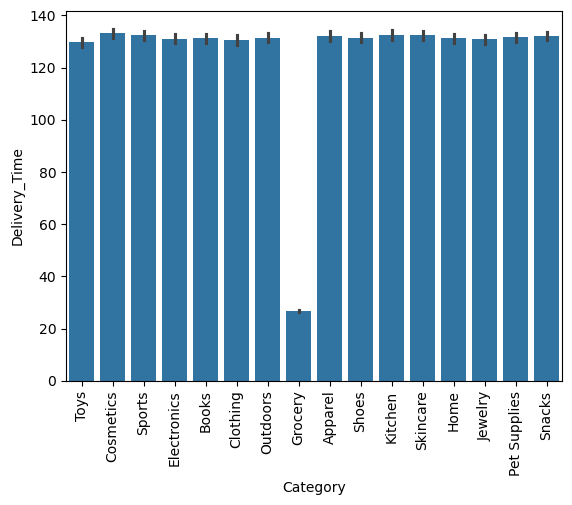

In [190]:
sns.barplot(x="Category", y="Delivery_Time", data=data)
plt.xticks(rotation=90)
plt.show()

In [191]:
data["Grocery_vs_Not"] = np.where(data["Category"] == "Grocery",1,0)

In [192]:
data.drop(["Category","Area"],axis=1, inplace=True)

# **One-hot-enconding**

In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43280 entries, 23614 to 18228
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Agent_Age               43280 non-null  int64   
 1   Agent_Rating            43280 non-null  float64 
 2   Drop_Latitude           43280 non-null  float64 
 3   Drop_Longitude          43280 non-null  float64 
 4   Weather                 43280 non-null  category
 5   Traffic                 43280 non-null  category
 6   Vehicle                 43280 non-null  category
 7   Delivery_Time           43280 non-null  int64   
 8   Distance_Store_Drop_km  43280 non-null  float64 
 9   abs_Store_Latitude      43280 non-null  float64 
 10  abs_Store_Longitude     43280 non-null  float64 
 11  Date_fraction           43280 non-null  float64 
 12  Duration_order_pickup   43280 non-null  float64 
 13  Grocery_vs_Not          43280 non-null  int32   
dtypes: category(3), float64

In [194]:
dummies = pd.get_dummies(data, drop_first=True)

# **Dimension reduction**

In [195]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43280 entries, 23614 to 18228
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Agent_Age               43280 non-null  int64  
 1   Agent_Rating            43280 non-null  float64
 2   Drop_Latitude           43280 non-null  float64
 3   Drop_Longitude          43280 non-null  float64
 4   Delivery_Time           43280 non-null  int64  
 5   Distance_Store_Drop_km  43280 non-null  float64
 6   abs_Store_Latitude      43280 non-null  float64
 7   abs_Store_Longitude     43280 non-null  float64
 8   Date_fraction           43280 non-null  float64
 9   Duration_order_pickup   43280 non-null  float64
 10  Grocery_vs_Not          43280 non-null  int32  
 11  Weather_Cloudy          43280 non-null  bool   
 12  Weather_Fog             43280 non-null  bool   
 13  Weather_Windy           43280 non-null  bool   
 14  Weather_Stormy          43280 non-null 

In [196]:
scaler = StandardScaler()
dummies = dummies.sample(frac=1, random_state=1984)
X = dummies.drop("Delivery_Time", axis=1)
y = dummies["Delivery_Time"]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=1984)

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

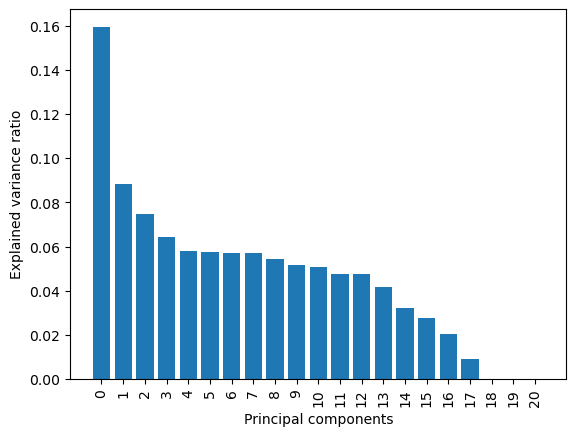

In [197]:
pca_orig = PCA()
pca_orig.fit(X_train_scale)
expl_variance_ratio = pca_orig.explained_variance_ratio_
princ_cpnts = range(pca_orig.n_components_)

plt.bar(x=princ_cpnts, height=expl_variance_ratio)
plt.xticks(princ_cpnts, rotation=90)
plt.xlabel("Principal components")
plt.ylabel("Explained variance ratio")
plt.show()

In [198]:
np.sum(expl_variance_ratio[0:12])

0.8218068321478805

Half of the features explains 76% of the total variance of the data.  
This dataset will be very difficult to use for prediction. I will try to reduce the to 12 principal components then. 

In [199]:
pca_12 = PCA(n_components=12)
scaler_2 = StandardScaler()
X_scaled = scaler_2.fit_transform(X)
X_12_PC = pca_12.fit_transform(X_scaled)
PCA_X= [f"PC{i}" for i in range(12)]
data_Princip_cpnts = pd.DataFrame(X_12_PC, columns=PCA_X)

In [200]:
len(data_Princip_cpnts)

43280

# **Neuronal network**

## **Multi-layer Perceptron (MLP)**

In [201]:
model = Sequential()
model.add(layers.Input((12,)))
model.add(layers.Dense(12, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(8, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(4, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1))

model.compile(optimizer = "sgd", loss = "mean_absolute_error", metrics=["mse","mae"])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397 (1.55 KB)

 Trainable params: 349 (1.36 KB)

 Non-trainable params: 48 (192.00 B)

## **Train_test_split**

In [202]:
print(len(PCA_X))
print(len(y))


12
43280


In [203]:
X_train2,X_test2,y_train,y_test = train_test_split(data_Princip_cpnts,y, test_size=0.3, random_state=1984)


## **Testing/evaluating the model**

In [205]:
X_frac = X_train2.sample(frac=0.5, random_state=1984)
y_frac = y_train.sample(frac=0.5, random_state=1984)

history = model.fit(X_frac,y_frac,epochs=60, validation_split=0.2)
validatio_mae = history.history["val_loss"]
train_mae = history.history["loss"]

Epoch 1/60
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24.3101 - mae: 24.3101 - mse: 1041.3269 - val_loss: 45.1845 - val_mae: 45.1845 - val_mse: 4040.5188
Epoch 2/60
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 29.4465 - mae: 29.4465 - mse: 1458.5333 - val_loss: 27.6157 - val_mae: 27.6157 - val_mse: 1212.3383
Epoch 3/60
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 27.9711 - mae: 27.9711 - mse: 1294.8010 - val_loss: 29.0879 - val_mae: 29.0879 - val_mse: 1303.2031
Epoch 4/60
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26.9829 - mae: 26.9829 - mse: 1221.3141 - val_loss: 25.3393 - val_mae: 25.3393 - val_mse: 1047.2043
Epoch 5/60
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26.0822 - mae: 26.0822 - mse: 1138.3674 - val_loss: 24.5783 - val_mae: 24.5783 - val_mse: 978.0982
Epoch 6/60
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 25.3099 - mae: 25.3099 - mse: 1071.1125 - val_loss: 26.6815 - val_mae: 26.6815 - val_mse: 1188.2654
Epoch 7/60
379/379 ━━━━━━━━━━━━━━━━━━━━ 1

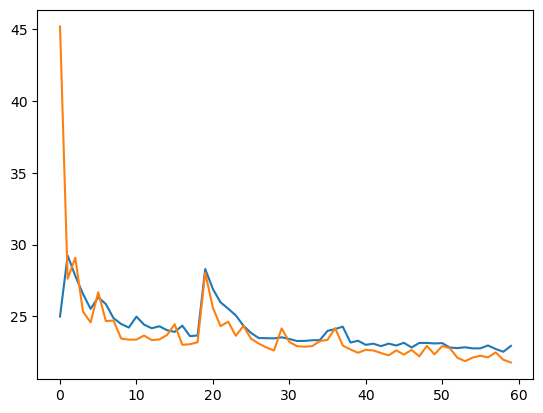

In [206]:
plt.figure()
plt.plot(train_mae)
plt.plot(validatio_mae)
plt.show()

## **Real situation**

In [207]:
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=15)

model_save = callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

model.fit(X_train2,y_train, epochs=100, validation_split=0.2,\
          callbacks=[early_stop,model_save], batch_size=100)


Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.6288 - mae: 21.6288 - mse: 802.2187 - val_loss: 21.3507 - val_mae: 21.3507 - val_mse: 773.8300
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.8304 - mae: 21.8304 - mse: 812.8130 - val_loss: 21.1979 - val_mae: 21.1979 - val_mse: 772.9793
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.5608 - mae: 21.5608 - mse: 801.9296 - val_loss: 21.2556 - val_mae: 21.2556 - val_mse: 773.4161
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.7791 - mae: 21.7791 - mse: 816.7393 - val_loss: 21.2139 - val_mae: 21.2139 - val_mse: 767.4004
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.3702 - mae: 21.3702 - mse: 787.2566 - val_loss: 20.9884 - val_mae: 20.9884 - val_mse: 760.9078
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.4055 - mae: 21.4055 - mse: 790.1289 - val_loss: 21.1689 - val_mae: 21.1689 - val_mse: 768.7662
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2m

In [208]:
predictions = model.predict(X_test2)

406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


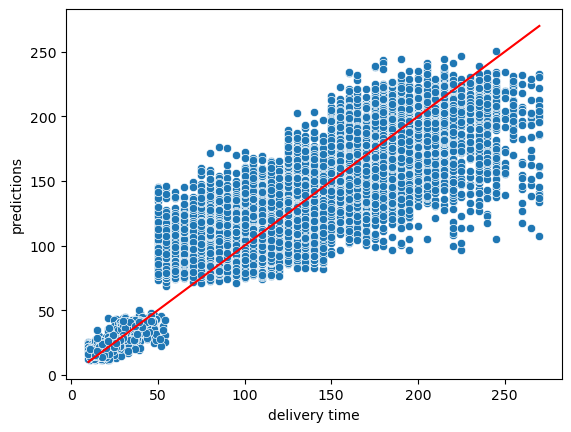

In [209]:
Delivery_time = pd.DataFrame(y_test.values, columns=["delivery time"])
Delivery_time["predictions"] = predictions

sns.scatterplot(x="delivery time", y="predictions", data=Delivery_time)
sns.lineplot(x="delivery time", y="delivery time", data=Delivery_time, color = "red")
plt.show()

In [210]:
MAE = mae(y_test,predictions)
print(MAE)

20.72443165635152


This neural network is about 8 min better (in term of mean absolute error) than the best ridge model I found. 